In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

# Maximizar el número personas testadas con una cantidad fija de pruebas diagnósticas

Si tenemos una prueba diagnóstica, podemos poner en contacto saliva, o sangre de una persona con esa prueba diagnóstica, y obtener un resultado inmediato: esa persona tiene, o no tiene, la enfermedad.

Pero también podemos arriesgarnos, y juntar la saliva, o sangre, de dos personas:
 - Si el resultado es negativo, hemos conseguido dos diagnósticos con una sóla prueba.
 - Si el resultado es positivo, necesitamos hacer la prueba a uno de los individuos:
     + Si el individuo da negativo, sabemos que el otro individuo da positivo, y hemos necesitado dos pruebas: lo comido por lo servido.
     + Si el individuo da positivo, no sabemos nada sobre el otro individuo: le tenemos que aplicar la prueba, y hemos necesitado en total tres pruebas, peor que si lo hubiéramos hecho de la manera obvia.

Esta técnica se llama [Group testing](https://en.wikipedia.org/wiki/Group_testing), se usa para muchas enfermedades desde hace mucho tiempo y ya se está usando en Islandia, Israel, Nebraska y Argentina, pero el grueso de países no la usan todavía (8 de abril de 2020):

 - https://www.forbes.com/sites/kotlikoff/2020/03/29/group-testing-is-our-secret-weapon-against-coronavirus/
 - https://www.lanacion.com.ar/opinion/investigadores-argentinos-desarrollan-sistema-hacer-muchos-mas-nid2351356

El objetivo de este cuaderno es considerar la posibilidad de juntar muestras de varias personas en una sóla prueba para conseguir diagnosticar al mayor número de personas con la cantidad de pruebas diagnósticas disponibles. El resultado depende de la proporción de infectados: para un 1% de infectados, haciendo pruebas agrupadas, ¡podemos diagnosticar más de 10 personas por cada prueba diagnóstica (1)!

_(1) en promedio y para cantidades moderadas de personas y de pruebas_

## Algunas estrategias

### Primera idea: le hacemos un test a cada persona del grupo

¿Cuántos tests necesito para encontrar a las personas infectadas en un grupo de `n` personas, Sherlock?

In [2]:
def num_tests_naive(sujetos):
    return len(sujetos)

In [3]:
grupos =[
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
        [0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1],
]

Con esta estrategia, no hay riesgo: siempre necesitamos tantas pruebas como personas.

In [4]:
for grupo in grupos:
    print(grupo, '=>', num_tests_naive(grupo))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] => 16
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] => 16
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] => 16
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] => 16
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] => 16
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] => 16
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] => 16
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] => 16
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1] => 16


### Siguiente idea: testeo binario

Vienen 16 personas: les hacemos un test conjunto, mezclando un poco de la saliva de cada uno. Si el test da `-`, hemos confirmado 16 `-`s con una sola prueba: ¡un gran ahorro de tests!

El número de pruebas necesarias depende mucho del grupo en concreto:
 - Depende obviamente del número de infectados en el grupo. Con 0 infectados en el grupo, el test es óptimo, pero si hay 1 infectado, hay que buscarlo.
 - Cada test con resultado `-` aporta más información que un test con resultado `+`. Si un test con n personas da resultado `-`, sabemos que todas esas personas no tienen la enfermedad, pero si es `+`, tenemos que hacer más pruebas, para decidir quién de todas esas personas tiene la enfermedad y quién no.
 - Además del número de infectados, depende de las posiciones que ocupan en la lista. Si el primer test, a las 16 personas es `+`, y el segundo, a los 8 primeros, es `-`, no necesitamos hacer el test a los 8 segundos para saber que hay un `+` entre ellos (_¿estás de acuerdo, Sherlock?_). Sin embargo, si el primer test, a las 16 personas es `+`, y el segundo, a los 8 primeros (sujetos del 1 al 8), es también `+`, no sabemos absolutamente nada sobre las otras 8 personas (sujetos del 9 al 16).

La manera más clara de programar este método es de forma recursiva:
  - Llegan `n` personas, y hacemos un test con un poco de la saliva de cada uno.
  - Si el resultado es `-`, hemos terminado.
  - Si el resultado es `+`, hacemos un test conjunto a la primera mitad:
      + Si el resultado es `-`, deducimos, sin hacer ningún test, que en la segunda mitad hay un infectado, pero tenemos que seguir probando hasta averiguar quiénes. Tardamos lo mismo que tardaríamos si este grupo llegar de la calle, pero nos hemos ahorrado el primer test.
      + Si el resultado de la primera mitad es `+`, tenemos que tratar por separado con la primera y con la segunda mitad. De la primera mitad sabemos que hay al menos un infectado, de la seguna no sabemos nada.

In [5]:
def num_tests_binary(sujetos):
    if sum(sujetos)==0 or len(sujetos)==1:
        return 1
    else:
        n = len(sujetos)//2
        test = sum(sujetos[:n])
        if test==0:
            #el primer 1 es el test conjunto
            #el segundo 1 es el test a la primera mitad
            #num_tests_binary(sujetos[n:]) es el n de tests necesarios para
            #  encontrar a los infectados en la segunda mitad, si no sabes
            #  nada sobre ese grupo
            #(num_tests_binary(sujetos[n:]) - 1): restamos 1 porque hemos
            #  deducido que el test conjunto de sujetos[n:] es positivo
            return 1 + 1 + (num_tests_binary(sujetos[n:]) - 1)
        else:
            return 1 + num_tests_binary(sujetos[:n]) + num_tests_binary(sujetos[n:])

Observamos que esta estrategia a veces ahorra pruebas, pero a veces es menos eficiente que la estrategia naive. En general, cuanto menos infectados, más eficiente.

In [6]:
for grupo in grupos:
    print(grupo, '=> ', num_tests_binary(grupo))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] =>  1
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] =>  8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] =>  5
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] =>  9
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] =>  11
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] =>  12
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] =>  11
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] =>  15
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1] =>  21


### Estrategia "óptima" para un tamaño de grupo fijo.

Nos preguntamos:

 - ¿Es lo mejor hacer un test conjunto a todo el grupo como primer paso?
 - Si el test de un grupo es positivo: ¿es lo mejor hacer un test conjunto a la primera mitad del grupo?
 - ¿Hay un tamaño óptimo para subdividir al grupo?
 - ¿Depende ese tamaño óptimo de la proporción de la población que tiene la enfermedad?

Asumimos que el grupo es una muestra aleatoria independiente de una población donde la proporción de enfermos es `p`.

Usamos un enfoque recursivo:

 - __test normal__: Si llegan `n` personas que no sabemos si están infectadas, separamos un grupo de `j = j(n)` y les hacemos un test conjunto:
     + Si el test es `-`, certificamos esas `j` personas como no infectadas, y para las `n-j` restantes hacemos un "test normal para `n-j` personas".
     + Si el test es `+`, hacemos a esas `j` personas un "test para `j` personas con positivo", y para las `n-j` restantes hacemos un "test normal para `n-j` personas".
 - __test con positivo__: Si llegan `n` personas de las que sabemos que alguna está infectada, separamos un grupo de `k = k(n)` y les hacemos un test conjunto:
     + Si el test es `-`, certificamos esas `k` personas como no infectadas, y para las `n-k` restantes hacemos un "test para `n-k` personas con positivo".
     + Si el test es `+`, hacemos a esas `k` personas un "test para `k` personas con positivo", y para las `n-k` restantes hacemos un "test normal para `n-k` personas".

Elegimos los valores de `j(n)` y de `k(n)` de modo que se minimice el número esperado de tests necesarios para encontrar a todos los infectados.

De esta forma obtenemos un sistema de ecuaciones recursivas para:

 - el número esperado de tests `t(n)`, para identificar a los infectados en un grupo de `n` personas sin información previa.
 - el número esperado de tests `r(n)`, para identificar a los infectados en un grupo de `n` personas del que sabemos que contiene al menos un infectado.

In [7]:
class Strategy():
    
    def __init__(self, p, nmax=16):
        self.nmax = nmax
        self.p = p
        self.t = t = {0:0, 1:1}
        self.r = r = {1:0}
        self.jt = jt = {1:1}
        self.jr = jr = {}
        q = 1 - p
        for n in range(2,nmax+1):
            r[n], jr[n] = min( 
                (1 + 
                 (q**j*(1-q**(n-j))/(1-q**n))*r[n-j] +
                 ((1-q**j)/(1-q**n))*(r[j] + t[n-j]), 
                 j)  for j in range(1,n)
            )
            t[n], jt[n] = min( 
                (1 + t[n-j] + (1-q**j)*r[j], j)
                for j in range(1,n+1)
            )

    def num_tests(self, sujetos):
        n = len(sujetos)
        if n<=1:
            return n
        j = self.jt[n]
        test = sum(sujetos[:j])
        if test:
            return 1 + self.num_tests_pos(sujetos[:j]) + self.num_tests(sujetos[j:])
        else:
            return 1 + self.num_tests(sujetos[j:])
    
    def num_tests_pos(self, sujetos):
        n = len(sujetos)
        if n<=1:
            return 0
        j = self.jr[n]
        test = sum(sujetos[:j])
        if test:
            return 1 + self.num_tests_pos(sujetos[:j]) + self.num_tests(sujetos[j:])
        else:
            return 1 + self.num_tests_pos(sujetos[j:])
        

In [8]:
S = Strategy(p=0.1)
num_tests_v3 = S.num_tests

In [9]:
for grupo in grupos:
    print(num_tests_naive(grupo),
          num_tests_binary(grupo),
          num_tests_v3(grupo))

16 1 2
16 8 7
16 5 6
16 9 8
16 11 11
16 12 12
16 11 14
16 15 14
16 21 18


## Comparando las estrategias seriamente

Ahora comparamos las estrategias bajo distintas hipótesis: elegimos distintos niveles de `p` (la proporción de infectados). Para cada nivel de `p`, generamos una muestra aleatoria de grupos de tamaño `n`, y probamos el número de pruebas necesarias para diagnosticar por completo a cada grupo. Obtenemos un promedio para cada estrategia y para cada `p`.

 - La estrategia naive siempre necesita n pruebas para un grupo de tamaño `n`
 - La estrategia binaria obtendrá distintos resultados dependiendo de `p`: para `p` pequeño lo hace mejor que la naive, pero para `p` grande lo hace peor.
 - La "estrategia óptima" depende del nivel `p0` estimado al generar la estrategia: ¿y si la estimación `p0` es distinta del nivel `p` real? Entonces la estrategia no es óptima en general. Al generar la estrategia óptima (mediante **programación dinámica**) generamos una estimación del número de pruebas necesarias. _Esta estimación coincide, salvo error numérico, con el promedio obtenido mediante simulación únicamente cuando `p` es igual a `p0`_.
 
La entropía del grupo de `n` personas es `-n * ( p * log(p) + (1-p) * log(1-p)  )`, y es una cota inferior al número de tests necesarios. La estrategia "óptima" no alcanza en general la entropía porque está limitada a un tamaño de grupo impuesto, y porque está obligada a elegir un número entero de personas para hacer una prueba conjunta, pero veremos que no se aleja mucho en general, si el tamaño de grupo es lo bastante grande.

In [10]:
Nsample = 1000
n = 16
def random01(p):
    return (random.random()<p)

def random_group(p, n=n):
    return [random01(p) for _ in range(n)]

proportions = np.linspace(0.05, 0.5, 10)
strats = ((p, Strategy(p)) for p in proportions)
strategies = [
    ('naive', num_tests_naive),
    ('binary', num_tests_binary)
] + [('Strategy(%.2f), test in groups of %d, theoretical expected number'
      ' of tests for a group of size %d: %.3f'%(p, S.jt[n], n, S.t[n]),
      S.num_tests, )
     for p,S in strats]

for p in proportions:
    print('-'*10 + ' p=%.2f '%p + '-'*10)
    print(' Entropy: ', -n*(p*np.log2(p) + (1-p)*np.log2(1-p) ))
    samples = [random_group(p) for _ in range(Nsample)]
    for stratname, strat in strategies:
        mean_num_tests = sum(strat(group) for group in samples)/Nsample
        print(stratname, mean_num_tests)
    

---------- p=0.05 ----------
 Entropy:  4.5823513138553
naive 16.0
binary 5.116
Strategy(0.05), test in groups of 16, theoretical expected number of tests for a group of size 16: 5.142 5.033
Strategy(0.10), test in groups of 8, theoretical expected number of tests for a group of size 16: 8.104 5.182
Strategy(0.15), test in groups of 4, theoretical expected number of tests for a group of size 16: 10.365 6.252
Strategy(0.20), test in groups of 3, theoretical expected number of tests for a group of size 16: 12.030 6.892
Strategy(0.25), test in groups of 2, theoretical expected number of tests for a group of size 16: 13.438 7.613
Strategy(0.30), test in groups of 2, theoretical expected number of tests for a group of size 16: 14.480 9.152
Strategy(0.35), test in groups of 2, theoretical expected number of tests for a group of size 16: 15.420 9.152
Strategy(0.40), test in groups of 1, theoretical expected number of tests for a group of size 16: 16.000 16.0
Strategy(0.45), test in groups of 

Si tenemos que diagnosticar a un grupo de tamaño `n`, ¿cuál es el tamaño óptimo del subgrupo para evaluar en conjunto?

El resultado depende de nuestra estimación del porcentaje de positivos.

In [11]:
S = Strategy(p=0.1)
for n in range(2, S.nmax+1):
    print('For a group of size %d, test a group of size %d'%(n, S.jt[n]))
for n in range(2, S.nmax+1):
    print('For a group of size %d that is known to contain a +, test a group of size %d'%(n, S.jr[n]))

For a group of size 2, test a group of size 2
For a group of size 3, test a group of size 3
For a group of size 4, test a group of size 4
For a group of size 5, test a group of size 5
For a group of size 6, test a group of size 6
For a group of size 7, test a group of size 7
For a group of size 8, test a group of size 8
For a group of size 9, test a group of size 9
For a group of size 10, test a group of size 5
For a group of size 11, test a group of size 5
For a group of size 12, test a group of size 5
For a group of size 13, test a group of size 8
For a group of size 14, test a group of size 7
For a group of size 15, test a group of size 7
For a group of size 16, test a group of size 8
For a group of size 2 that is known to contain a +, test a group of size 1
For a group of size 3 that is known to contain a +, test a group of size 1
For a group of size 4 that is known to contain a +, test a group of size 1
For a group of size 5 that is known to contain a +, test a group of size 2
For

In [12]:
S = Strategy(p=0.2, nmax=10)
for n in range(2, S.nmax+1):
    print('For a group of size %d, test a group of size %d'%(n, S.jt[n]))
for n in range(2, S.nmax+1):
    print('For a group of size %d that is known to contain a +, test a group of size %d'%(n, S.jr[n]))

For a group of size 2, test a group of size 2
For a group of size 3, test a group of size 3
For a group of size 4, test a group of size 4
For a group of size 5, test a group of size 3
For a group of size 6, test a group of size 3
For a group of size 7, test a group of size 3
For a group of size 8, test a group of size 2
For a group of size 9, test a group of size 3
For a group of size 10, test a group of size 3
For a group of size 2 that is known to contain a +, test a group of size 1
For a group of size 3 that is known to contain a +, test a group of size 1
For a group of size 4 that is known to contain a +, test a group of size 1
For a group of size 5 that is known to contain a +, test a group of size 2
For a group of size 6 that is known to contain a +, test a group of size 2
For a group of size 7 that is known to contain a +, test a group of size 2
For a group of size 8 that is known to contain a +, test a group of size 2
For a group of size 9 that is known to contain a +, test a g

In [13]:
S = Strategy(p=0.05, nmax=30)
for n in range(2, S.nmax+1):
    print('For a group of size %d, test a group of size %d'%(n, S.jt[n]))
for n in range(2, S.nmax+1):
    print('For a group of size %d that is known to contain a +, test a group of size %d'%(n, S.jr[n]))

For a group of size 2, test a group of size 2
For a group of size 3, test a group of size 3
For a group of size 4, test a group of size 4
For a group of size 5, test a group of size 5
For a group of size 6, test a group of size 6
For a group of size 7, test a group of size 7
For a group of size 8, test a group of size 8
For a group of size 9, test a group of size 9
For a group of size 10, test a group of size 10
For a group of size 11, test a group of size 11
For a group of size 12, test a group of size 12
For a group of size 13, test a group of size 13
For a group of size 14, test a group of size 14
For a group of size 15, test a group of size 15
For a group of size 16, test a group of size 16
For a group of size 17, test a group of size 17
For a group of size 18, test a group of size 18
For a group of size 19, test a group of size 19
For a group of size 20, test a group of size 20
For a group of size 21, test a group of size 21
For a group of size 22, test a group of size 11
For a gr

## Factor multiplicador

¿Cuál es la ganacia? Comparamos el ratio de tests necesarios con esta estrategia para un 1% de gente infectada: cada test se multiplica `x10.37` usando grupos lo bastante grandes y testeando de forma óptima. El límite superior impuesto por la entropía es de `x12.38`.

In [14]:
p0 = 0.01
S = Strategy(p=p0, nmax=400)
print('maximum multiplier = 1/(Entropy of one individual) = ', (-1)/(p0*np.log2(p0) + (1-p0)*np.log2(1-p0)))
for n in range(10, S.nmax+1, 10):
    print('n=%2d, test in groups of size %d, multiplier: %.2f'%(n, S.jt[n], 1/(S.t[n]/n)))

maximum multiplier = 1/(Entropy of one individual) =  12.377289096543269
n=10, test in groups of size 10, multiplier: 6.75
n=20, test in groups of size 20, multiplier: 9.00
n=30, test in groups of size 30, multiplier: 9.81
n=40, test in groups of size 40, multiplier: 10.15
n=50, test in groups of size 50, multiplier: 10.30
n=60, test in groups of size 60, multiplier: 10.36
n=70, test in groups of size 70, multiplier: 10.36
n=80, test in groups of size 80, multiplier: 10.37
n=90, test in groups of size 90, multiplier: 10.36
n=100, test in groups of size 100, multiplier: 10.32
n=110, test in groups of size 55, multiplier: 10.36
n=120, test in groups of size 55, multiplier: 10.36
n=130, test in groups of size 55, multiplier: 10.37
n=140, test in groups of size 55, multiplier: 10.37
n=150, test in groups of size 74, multiplier: 10.37
n=160, test in groups of size 76, multiplier: 10.37
n=170, test in groups of size 89, multiplier: 10.37
n=180, test in groups of size 89, multiplier: 10.37
n=

Para un 0.1% de infectados, el multiplicador es `x69`.

In [15]:
p0 = 0.001
S = Strategy(p=p0, nmax=5000)
print('maximum multiplier = 1/(Entropy of one individual) = ', (-1)/(p0*np.log2(p0) + (1-p0)*np.log2(1-p0)))
for n in range(50, S.nmax+1, 50):
    print('n=%2d, test in groups of size %d, multiplier: %.2f'%(n, S.jt[n], 1/(S.t[n]/n)))

maximum multiplier = 1/(Entropy of one individual) =  87.65964556874923
n=50, test in groups of size 50, multiplier: 35.51
n=100, test in groups of size 100, multiplier: 51.14
n=150, test in groups of size 150, multiplier: 58.89
n=200, test in groups of size 200, multiplier: 62.98
n=250, test in groups of size 250, multiplier: 65.47
n=300, test in groups of size 300, multiplier: 66.89
n=350, test in groups of size 350, multiplier: 67.94
n=400, test in groups of size 400, multiplier: 68.56
n=450, test in groups of size 450, multiplier: 68.88
n=500, test in groups of size 500, multiplier: 69.15
n=550, test in groups of size 550, multiplier: 69.36
n=600, test in groups of size 600, multiplier: 69.55
n=650, test in groups of size 650, multiplier: 69.53
n=700, test in groups of size 700, multiplier: 69.50
n=750, test in groups of size 750, multiplier: 69.49
n=800, test in groups of size 800, multiplier: 69.47
n=850, test in groups of size 850, multiplier: 69.46
n=900, test in groups of size

### La estrategia binaria no es mala cuando p es pequeño

Aunque la estrategia binaria no es óptima, y es mala cuando p es grande, es razonablemente buena cuando p es pequeño.

In [24]:
Nsample = 1000
p=0.01

ns = [2**k for k in range(4,12)]
S = Strategy(p, nmax=max(ns))

for n in ns:
    strategies = [
        ('binary', num_tests_binary), 
        ('Strategy(0.01), test in groups of %d, theoretical expected number'
          ' of tests for a group of size %d: %.3f'%(S.jt[n], n, S.t[n]),
          S.num_tests)
    ]

    print('-'*10 + ' n=%3d '%n + '-'*10)
    print(' Entropy: ', -n*(p*np.log2(p) + (1-p)*np.log2(1-p) ))
    samples = [random_group(p,n) for _ in range(Nsample)]
    for stratname, strat in strategies:
        mean_num_tests = sum(strat(group) for group in samples)/Nsample
        print(stratname, mean_num_tests)

---------- n= 16 ----------
 Entropy:  1.292690174334579
binary 1.85
Strategy(0.01), test in groups of 16, theoretical expected number of tests for a group of size 16: 1.915 1.819
---------- n= 32 ----------
 Entropy:  2.585380348669158
binary 3.393
Strategy(0.01), test in groups of 32, theoretical expected number of tests for a group of size 32: 3.226 3.289
---------- n= 64 ----------
 Entropy:  5.170760697338316
binary 6.447
Strategy(0.01), test in groups of 64, theoretical expected number of tests for a group of size 64: 6.178 6.28
---------- n=128 ----------
 Entropy:  10.341521394676631
binary 12.71
Strategy(0.01), test in groups of 55, theoretical expected number of tests for a group of size 128: 12.348 12.155
---------- n=256 ----------
 Entropy:  20.683042789353262
binary 26.807
Strategy(0.01), test in groups of 78, theoretical expected number of tests for a group of size 256: 24.686 25.124
---------- n=512 ----------
 Entropy:  41.366085578706524
binary 52.797
Strategy(0.01), 

In [26]:
Nsample = 1000
p=0.001

ns = [2**k for k in range(8,13)]
S = Strategy(p, nmax=max(ns))

for n in ns:
    strategies = [
        ('binary', num_tests_binary), 
        ('Strategy(0.01), test in groups of %d, theoretical expected number'
          ' of tests for a group of size %d: %.3f'%(S.jt[n], n, S.t[n]),
          S.num_tests)
    ]

    print('-'*10 + ' n=%3d '%n + '-'*10)
    print(' Entropy: ', -n*(p*np.log2(p) + (1-p)*np.log2(1-p) ))
    samples = [random_group(p,n) for _ in range(Nsample)]
    for stratname, strat in strategies:
        mean_num_tests = sum(strat(group) for group in samples)/Nsample
        print(stratname, mean_num_tests)

---------- n=256 ----------
 Entropy:  2.9203859807900514
binary 3.901
Strategy(0.01), test in groups of 256, theoretical expected number of tests for a group of size 256: 3.898 3.79
---------- n=512 ----------
 Entropy:  5.840771961580103
binary 7.237
Strategy(0.01), test in groups of 512, theoretical expected number of tests for a group of size 512: 7.397 7.096
---------- n=1024 ----------
 Entropy:  11.681543923160206
binary 15.044
Strategy(0.01), test in groups of 1024, theoretical expected number of tests for a group of size 1024: 14.771 14.493
---------- n=2048 ----------
 Entropy:  23.36308784632041
binary 31.565
Strategy(0.01), test in groups of 610, theoretical expected number of tests for a group of size 2048: 29.451 29.821
---------- n=4096 ----------
 Entropy:  46.72617569264082
binary 65.46
Strategy(0.01), test in groups of 610, theoretical expected number of tests for a group of size 4096: 58.901 61.056


## Conclusiones

 - Se puede mejorar la cantidad de personas diagnosticadas con la misma cantidad de reactivos/pruebas diagnósticas.
 - El factor multiplicador es mayor cuánto menor el porcentaje de infectados.
 - Hay formas de apurar todavía más y acercarse otro poco a la entropía.
 - Es muy fácil de implementar, al final sólo hay que dar a los técnicos de laboratorio una tabla de números: 
     + Comienza _siempre_ juntando $n_0$ muestras y haciendo una prueba conjunta. Si da `-`, reparte $n_0$ certificados de no-enfermo.
     + Si da `+`, busca en la tabla $n_0$ para encontrar el número $n_1$ de muestras que debes juntar en un subconjunto para la siguiente prueba.
         + Si la prueba del subconjunto da `-`, reparte $n_1$ certificados de no-enfermo, y busca $n_0 - n_1$ en la tabla para encontrar el nuevo número de muestras que debes juntar para la siguiente prueba.
         + Si la prueba del subconjunto da `+`, devuelve las $n_0 - n_1$ muestras que no han entrado en esta nueva prueba al pool de muestras pendientes, y busca $n_1$ en la tabla para encontrar el nuevo número de muestras que debes juntar para la siguiente prueba.         
 - Seguro que este resultado es bien conocido: ¿por qué no se habla de ésto?

## A posteriori

 - El group testing se ha terminado usando en USA y otros países, pero no en los términos descritos en este cuaderno, por varios factores:
   + Las pruebas PCR son lentas, de modo que es importante limitar la cantidad de pruebas diagnósticas necesarias para llegar a un resultado.
   + Las pruebas PCR fallan, así que debemos incorporar las dos probabilidades de fallo del test (falso positivo y falso negativo). Para tomar la decisión óptima, es necesario también introducir en el modelo la "utilidad de un positivo", la "penalización por no identificar a un negativo", la "penalización por hacer perder a un negativo un día de trabajo". Todo esto es posible, ni siquiera es difícil.
   + Lo más importante: es importante establecer los protocolos de testeo de modo que se minimice el error humano. En medio de una pandemia, con los medios sanitarios colapsados, no se pueden introducir nuevos protocolos más complejos para el personal de laboratorio.

### ETC

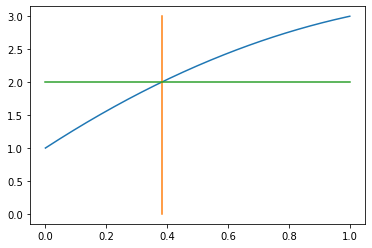

In [16]:
#Aparte:
#Calculo para n=2
# ¿Hasta qué proporción de infectados merece la pena testear de dos en dos?
# Respuesta: hasta un (3 - sqrt(5))/2 ~ 38% de infectados
ps = np.linspace(0,1,200)
ys = 2 + ps - (1-ps)**2
plt.plot(ps, ys)
r = (3 - np.sqrt(5))/2
plt.plot([r,r], [0,3])
plt.plot([0,1], [2,2])
